In [33]:
import pandas as pd
import numpy as np
import seaborn as sns
import torch

In [2]:
#  df.to_pickle("data/token_scores.pkl")

df = pd.read_pickle("../data/token_scores.pkl")
df

,passage,gpt-labels-refs,passage-tokens,diag_sep_passage,reranked_rollouts,grad_sam_scores,att_cat_scores
0,Respond to DMV insurance letters and orders //...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[Respond, to, DMV, insurance, letters, and, or...",My insurance ended so what should i do[SEP]Res...,"[tensor(0.0143), tensor(0.0026), tensor(0.0036...","[tensor(4.3173e-06), tensor(2.4501e-06), tenso...","[tensor(-0.0008), tensor(-0.0001), tensor(-0.0..."
1,Pay insurance lapse civil penalty // Pay ins...,"[tensor(1.), tensor(1.), tensor(1.), tensor(1....","[Pay, insurance, lapse, civil, penalty, /, /, ...",My insurance ended so what should i do[SEP]Pay...,"[tensor(0.0112), tensor(0.0089), tensor(0.0070...","[tensor(4.5446e-06), tensor(3.7075e-06), tenso...","[tensor(-0.0013), tensor(-0.0003), tensor(0.00..."
2,Top 5 DMV Mistakes and How to Avoid Them // ...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[Top, 5, DMV, Mistakes, and, How, to, Avoid, T...",My insurance ended so what should i do[SEP]Top...,"[tensor(0.0085), tensor(0.0022), tensor(0.0022...","[tensor(2.0746e-06), tensor(1.7868e-06), tenso...","[tensor(-0.0006), tensor(0.0002), tensor(-0.00..."
3,Respond to DMV insurance letters and orders //...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[Respond, to, DMV, insurance, letters, and, or...",My insurance ended so what should i do[SEP]Res...,"[tensor(0.0238), tensor(0.0064), tensor(0.0090...","[tensor(1.0645e-06), tensor(7.3783e-07), tenso...","[tensor(-0.0003), tensor(-8.0363e-05), tensor(..."
4,Insurance lapses // What will happen if I dr...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[Insurance, lapses, /, /, What, will, happen, ...",My insurance ended so what should i do[SEP]Ins...,"[tensor(0.0092), tensor(0.0042), tensor(0.0041...","[tensor(1.1722e-06), tensor(1.5205e-06), tenso...","[tensor(-0.0005), tensor(-0.0001), tensor(-6.1..."
...,...,...,...,...,...,...,...
1240,How to replace a registration // If your add...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[How, to, replace, a, registration, /, /, If, ...",I would need to change the address and name.ag...,"[tensor(0.0108), tensor(0.0031), tensor(0.0027...","[tensor(9.7100e-07), tensor(8.4490e-07), tenso...","[tensor(-3.4392e-05), tensor(-9.2082e-05), ten..."
1241,Replace license or permit // Replace at an o...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[Replace, license, or, permit, /, /, Replace, ...",I would need to change the address and name.ag...,"[tensor(0.0105), tensor(0.0025), tensor(0.0016...","[tensor(1.5006e-06), tensor(1.1599e-06), tenso...","[tensor(-0.0001), tensor(-0.0002), tensor(-5.6..."
1242,How to change your address // Update the add...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[How, to, change, your, address, /, /, Update,...",I would need to change the address and name.ag...,"[tensor(0.0102), tensor(0.0028), tensor(0.0014...","[tensor(5.6359e-07), tensor(4.6600e-07), tenso...","[tensor(-7.0898e-05), tensor(-7.9657e-05), ten..."
1243,How to replace a registration // If your nam...,"[tensor(0.), tensor(0.), tensor(0.), tensor(0....","[How, to, replace, a, registration, /, /, If, ...",I would need to change the address and name.ag...,"[tensor(0.0094), tensor(0.0023), tensor(0.0019...","[tensor(5.5299e-07), tensor(5.1595e-07), tenso...","[tensor(3.0823e-05), tensor(-5.8694e-05), tens..."


In [22]:

record = df.iloc[0]
record


passage              Respond to DMV insurance letters and orders //...
gpt-labels-refs      [tensor(0.), tensor(0.), tensor(0.), tensor(0....
passage-tokens       [Respond, to, DMV, insurance, letters, and, or...
diag_sep_passage     My insurance ended so what should i do[SEP]Res...
reranked_rollouts    [tensor(0.0143), tensor(0.0026), tensor(0.0036...
grad_sam_scores      [tensor(4.3173e-06), tensor(2.4501e-06), tenso...
att_cat_scores       [tensor(-0.0008), tensor(-0.0001), tensor(-0.0...
Name: 0, dtype: object

In [27]:
import custom_data_utils
from custom_data_utils import utils
from IPython.display import display, HTML

highlighted_passage = utils.create_highlighted_passage(record["passage-tokens"], 
                                 None,
                                 record["grad_sam_scores"],
                                 'green',
                                 'linear')
display(HTML("\n".join(highlighted_passage)))


<Axes: >

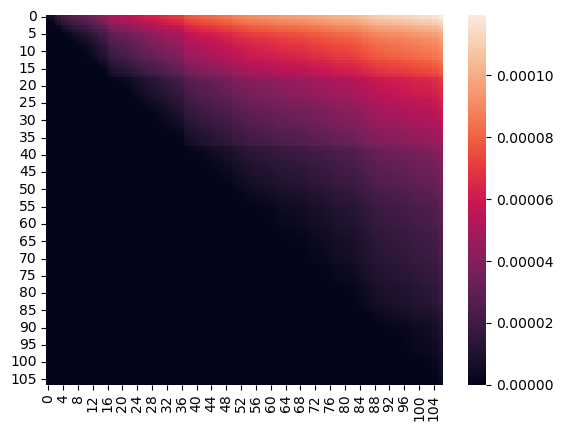

In [38]:
def calc_span_scores(a):
    a_rows = a.repeat((a.shape[-1], 1)).to(a.device)
    return torch.cumsum(torch.triu(a_rows), dim=-1)

cs_scores = calc_span_scores(record["grad_sam_scores"])
span_lens_default = calc_span_scores(torch.ones(record["grad_sam_scores"].size(0)))

sns.heatmap(cs_scores)

<Axes: >

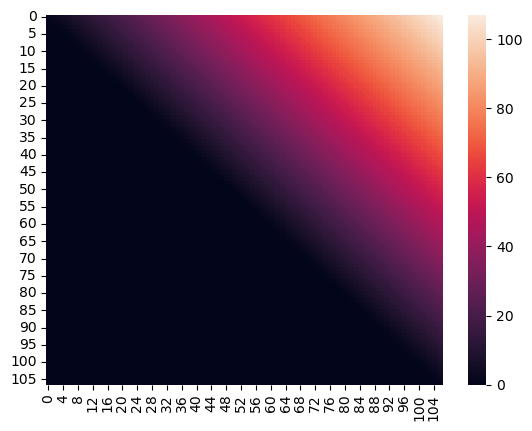

In [39]:
sns.heatmap(span_lens_default)


In [73]:
def span_aggregation(scores, N, K):
    span_lens = calc_span_scores(torch.ones(scores.size(0))).to(scores.device)
    return  ((1 + N) * (span_lens + K) / span_lens)

N = 22
K = 88

agg_scores = span_aggregation(cs_scores, N, K)
print(agg_scores)

yx = torch.nan_to_num(agg_scores, posinf=0)
print(yx)
sns.heatmap(yx)


tensor([[2047.0000, 1035.0000,  697.6667,  ...,   42.2762,   42.0943,
           41.9159],
        [      inf, 2047.0000, 1035.0000,  ...,   42.4615,   42.2762,
           42.0943],
        [      inf,       inf, 2047.0000,  ...,   42.6505,   42.4615,
           42.2762],
        ...,
        [      inf,       inf,       inf,  ..., 2047.0000, 1035.0000,
          697.6667],
        [      inf,       inf,       inf,  ...,       inf, 2047.0000,
         1035.0000],
        [      inf,       inf,       inf,  ...,       inf,       inf,
         2047.0000]])


In [63]:
agg_scores.min(), agg_scores.mean(), agg_scores.max(), 

(tensor(24.7196), tensor(inf), tensor(inf))